In [64]:
import cv2
import argparse
import logging
import os
from tqdm.auto import tqdm
from pathlib import Path

import numpy as np
from tracker.multitracker import JDETracker
from utils.timer import Timer

import matplotlib.pyplot as plt
from tracker.basetrack import TrackState
import torch
import pickle

from utils import visualization as vis

In [65]:
logger = logging.getLogger(__name__)

In [66]:
# path of video to use. Replace with integer to use /dev/video device
# that is, the webcam.
video_path = Path('OUT/embedding_test/V003.seq')
projector_pcl = Path('OUT/embedding_test/reducer_pca.pcl')

In [67]:
from utils.parse_config import parse_model_cfg
from utils.utils import mkdir_if_missing
import utils.datasets as datasets
from utils.log import logger as trmlog # we need to override this...


trmlog.setLevel(logging.INFO)

In [68]:
# load options; quick'n'dirty copy from track.py (as the Namespace object is used in the multitracker)
parser = argparse.ArgumentParser(prog='visualise_embeddings.py')
parser.add_argument('--cfg', type=str, default='cfg/yolov3_1088x608.cfg', help='cfg file path')
parser.add_argument('--weights', type=str, default='jde.1088x608.uncertainty.pt', help='path to weights file')
parser.add_argument('--iou-thres', type=float, default=0.5, help='iou threshold required to qualify as detected')
parser.add_argument('--conf-thres', type=float, default=0.5, help='object confidence threshold')
parser.add_argument('--nms-thres', type=float, default=0.4, help='iou threshold for non-maximum suppression')
parser.add_argument('--min-box-area', type=float, default=200, help='filter out tiny boxes')
parser.add_argument('--track-buffer', type=int, default=30, help='tracking buffer')
parser.add_argument('--dataset-dir', type=str, default="/datasets", help='Path to directory with datasets')
parser.add_argument('--experiment-name', type=str, default="embedding_test", help="name to prefix output directory with")
parser.add_argument('--output-dir', type=str, default="./OUT", help="directory for results")
    
# we're running in notebook, so default to empty
opt = parser.parse_args([])

logger.setLevel(logging.INFO)
result_path = os.path.join(opt.output_dir, opt.experiment_name)
result_frame_path = os.path.join(result_path, 'track-test')
mkdir_if_missing(result_path)
mkdir_if_missing(result_frame_path)
data_type = 'mot'

# Read config
cfg_dict = parse_model_cfg(opt.cfg)
# set img_size in opt, so it is passed on to JDETracker
opt.img_size = [int(cfg_dict[0]['width']), int(cfg_dict[0]['height'])]

In [77]:
result_frame_path

'./OUT/embedding_test/track-test'

In [69]:
import queue, threading

# bufferless VideoCapture (by Ulrich Stern: https://stackoverflow.com/a/54577746)
# Usefull when using Webcam with higher fps than the script can process it.
class BufferlessVideoCapture:

  def __init__(self, name):
    self.cap = cv2.VideoCapture(name)
    self.q = queue.Queue()
    t = threading.Thread(target=self._reader)
    t.daemon = True
    t.start()

  # read frames as soon as they are available, keeping only most recent one
  def _reader(self):
    while True:
      ret, frame = self.cap.read()
      if not ret:
        break
      if not self.q.empty():
        try:
          self.q.get_nowait()   # discard previous (unprocessed) frame
        except queue.Empty:
          pass
      self.q.put(frame)

  def read(self):
    return self.q.get()

In [70]:

with projector_pcl.open('rb') as fp:
   reducer = pickle.load(fp)

Load video file and get it's properties. Use that to calculate the dimension to fit the loaded model

In [74]:
# array with shape n-components, n-features
reducer.components_.shape

(2, 512)

In [59]:
stream = cv2.VideoCapture(str(video_path))
frame_rate = stream.get(cv2.CAP_PROP_FPS)
vw = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))
vh = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))


print("video", vw, "x", vh)

# get_size (from datasets.py)
aspect_w, aspect_h = float(opt.img_size[0]) / vw, float(opt.img_size[1]) / vh
aspect = min(aspect_w, aspect_h)
w, h = int(vw *aspect), int(vh*aspect)
print("Scale to", w, "x", h)


video 640 x 480
Scale to 810 x 608


In [60]:
umap_pcl = os.path.join(result_path, 'reducer_umap.pcl')
pca_pcl = os.path.join(result_path, 'reducer_pca.pcl')

(-1.0, 1.0)

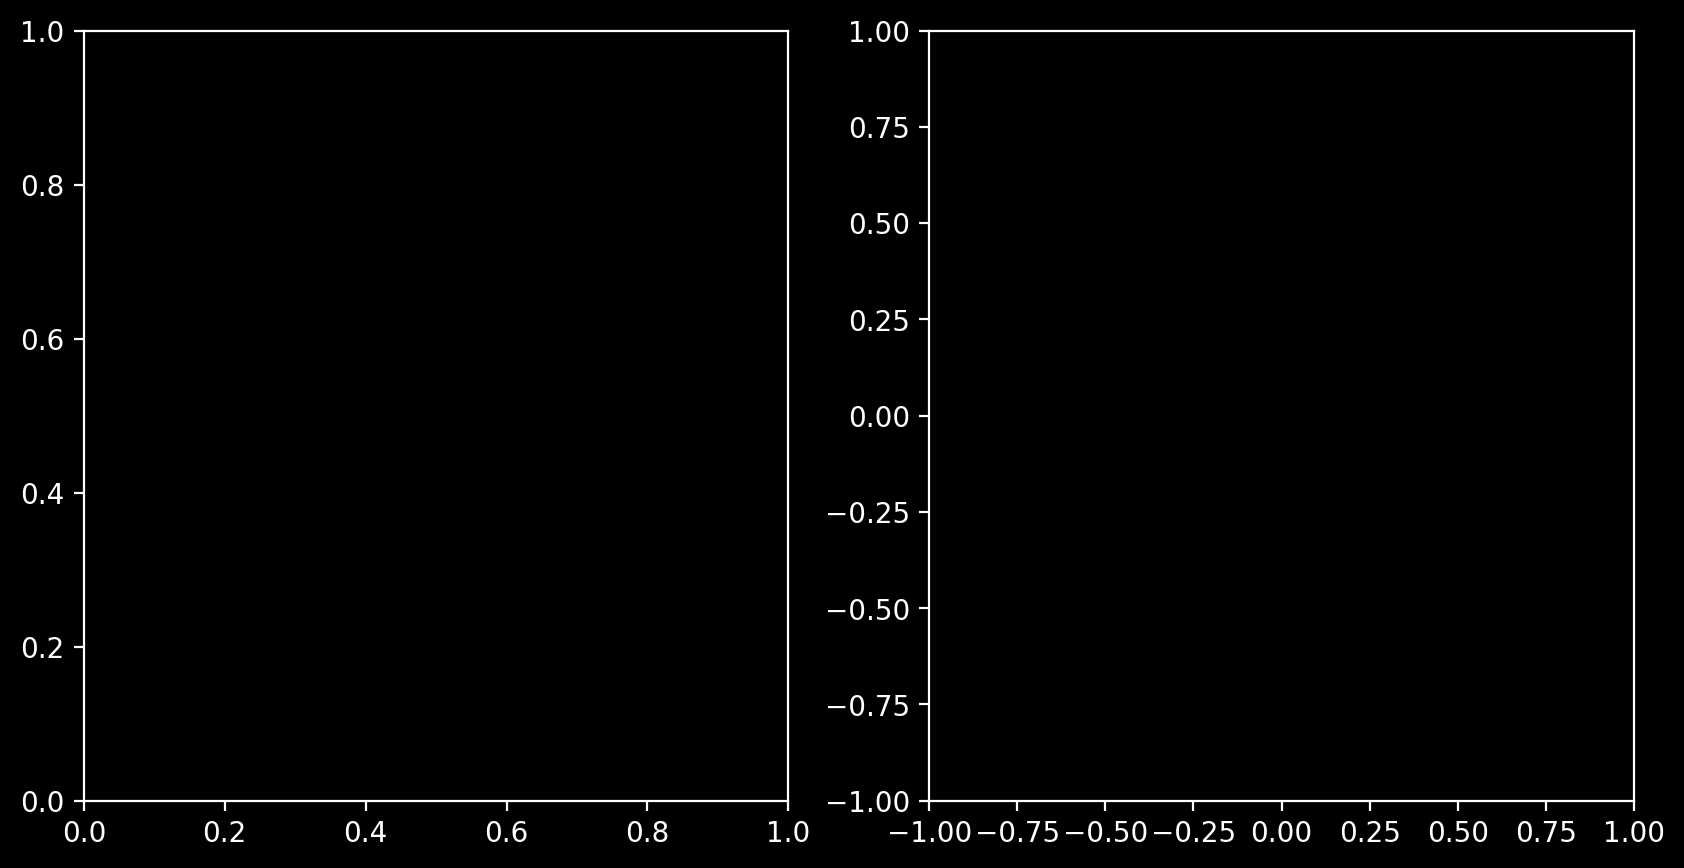

In [75]:
# matplotlib in interactive mode so the scatter can be updated.

plt.style.use('dark_background')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
x, y = [],[]
scatter = ax[1].scatter(x,y)
# scatter = ax.plot([],[],label='toto',ms=10,color='k',marker='o',ls='')
plt.xlim(-1,1)
plt.ylim(-1,1)


In [76]:
# init tracker
tracker = JDETracker(opt, frame_rate=frame_rate)
timer = Timer()
results = []
frame_id = -1


In [63]:
with tqdm() as pbar:
    while True:
        timer.tic()
        frame_id += 1

        pbar.update(1)

        ret, frame = stream.read()
        # scale down/up frame to fit tracker
        frame = cv2.resize(frame, (w, h))


        # letterbox as to have a constant size for the model
        img, _, _, _ = datasets.letterbox(frame, height=opt.img_size[1], width=opt.img_size[0])

        # Normalize RGB
        img = img[:, :, ::-1].transpose(2, 0, 1)
        img = np.ascontiguousarray(img, dtype=np.float32)
        img /= 255.0

        # send frame to GPU
        blob = torch.from_numpy(img).cuda().unsqueeze(0)

        # online targets: all targets that are not timed out
        # frame_embeddings: the embeddings of objects visible only in the current frame
        online_targets, frame_embeddings = tracker.update(blob, frame)

        # all relevant tracks from the tracker directly (excludes the 'removed' ones)
        # thus also accessing its those that it has stored from previous frames
        all_stracks = tracker.tracked_stracks + tracker.lost_stracks

        # project them to 2D using PCA (see visualise_embeddings.ipynb)
        if len(all_stracks):
            projections = reducer.transform([strack.smooth_feat for strack in all_stracks])
        else:
            projections = []

        timer.toc()


        online_tlwhs = []
        online_ids = []
        for t in online_targets:
            tlwh = t.tlwh
            tid = t.track_id
            vertical = tlwh[2] / tlwh[3] > 1.6
            if tlwh[2] * tlwh[3] > opt.min_box_area and not vertical:
                online_tlwhs.append(tlwh)
                online_ids.append(tid)
        # visualise results for single frame
        online_im = vis.plot_tracking(frame, online_tlwhs, online_ids, frame_id=frame_id,
                                            fps=1. / timer.average_time)
        
        # redraw the canvas
        # fig.canvas.draw()
        # ax[0].clear()
        # ax[1].clear()
        
        ax[0].imshow(online_im)
        # cv2.imwrite(result_frame_path + f"/{frame_id:04d}-live.jpg", online_im)


        # scatter.set_data(projections[:,0],projections[:,1])
        if len(projections):
            scatter.set_offsets(projections)
            scatter.set_color([(0,0,1,0.5) if strack.state == TrackState.Lost else (0,0,1,1) for strack in all_stracks])
        else:
            scatter = ax[1].scatter([],[])
            pbar.set_description('todo: empty axes')
            # print()

    #     plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    #     plot  = plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    #     # img is rgb, convert to opencv's default bgr
    #     plot = cv2.cvtColor(plot,cv2.COLOR_RGB2BGR)




        fig.savefig(result_frame_path + f"/{frame_id:04d}.png")

        # fig.canvas.draw_idle()
        # plt.pause(0.1)
    #     if cv2.waitKey(1) & 0xFF == ord('q'): # wait for 1 millisecond
    #         break

0it [00:00, ?it/s]

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [78]:
! ffmpeg -i OUT/embedding_test/track-test/%04d.png -c:v libx264 -crf 10  OUT/embedding_test/track-test.mp4

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw